In [45]:
%matplotlib inline

In [46]:
import os, sys
THIS_DIR = os.path.abspath(os.getcwd())
sys.path.append(os.path.join(THIS_DIR, ".."))

import fcm
import fcm.atmosphere as atm
import numpy as np
from scipy.sparse.construct import rand
import chromosome as ch
import fitness as fit
import pandas as pd
import tools as t
import GA_operation as ga
import matplotlib.pyplot as plt

In [47]:
# GA input parameters
# get the atmosphere of earth
atmosphere = atm.US_standard_atmosphere()
group_count = 1
event_count = 300
offspring_count = 300
observation = fit.read_event(fit.Event.lost_city)
iteration = 100

In [48]:
# generate the mating pool
strength_lower_bound = 1000
strength_higher_bound = 10000
veloctiy = 14.2
angle = 38
group_dataframe, meteoroids_frame, param_frame = ga.mate_pool_generater(group_count, event_count, observation, veloctiy, angle, strength_lower_bound, strength_higher_bound)

In [49]:
ga.accumulate_probability(param_frame)

# store every iteration's radius, ablation and fitness_value of each event
radius = np.zeros((iteration, offspring_count))
ablation = np.zeros((iteration, offspring_count))
erro_list = np.zeros((iteration, offspring_count))
fitness_list = np.zeros((iteration, offspring_count))

# the index of highest fitness value
highest = -1
is_break = False

In [50]:
for i in range(iteration):
    print("the iteration is ", i)
    # cross-over
    off_gd, off_m, off_p = ga.cross_over(group_dataframe, meteoroids_frame, param_frame, offspring_count, group_count)

    # mutation
    # ga.mutation(off_gd, off_m, off_p, group_count)

    # update the fitness
    is_break, highest = ga.update_fitness(off_gd, off_m, off_p, group_count, observation, erro_list[i], 1e-8)
    # update the parent dataframe
    group_dataframe = off_gd
    meteoroids_frame = off_m
    param_frame = off_p
    
    radius[i] = meteoroids_frame['radius'].to_numpy()
    ablation[i] = param_frame['ablation_coeff'].to_numpy()
    fitness_list[i] = param_frame['fitness_value'].to_numpy()

    if is_break is True:
        print("Converged at " + str(i) + " iteration in advance")
        break

    # get the accumulate probability
    ga.accumulate_probability(param_frame)

the iteration is  0
the iteration is  1
the iteration is  2
the iteration is  3
the iteration is  4
the iteration is  5
the iteration is  6
the iteration is  7
the iteration is  8
the iteration is  9
the iteration is  10
the iteration is  11
the iteration is  12
the iteration is  13
the iteration is  14
the iteration is  15
the iteration is  16
the iteration is  17
the iteration is  18
the iteration is  19
the iteration is  20
the iteration is  21
the iteration is  22
the iteration is  23
the iteration is  24
the iteration is  25
the iteration is  26
the iteration is  27
the iteration is  28
the iteration is  29
the iteration is  30
the iteration is  31
the iteration is  32
the iteration is  33
the iteration is  34
the iteration is  35
the iteration is  36
the iteration is  37
the iteration is  38
the iteration is  39
the iteration is  40
the iteration is  41
the iteration is  42
the iteration is  43
the iteration is  44
the iteration is  45
the iteration is  46
the iteration is  47
th

In [37]:
ga.discrete_fitness(param_frame)

if not is_break:
    highest = param_frame['fitness_value'].idxmax()
else:
    print("The highest index is " + str(highest))

In [38]:
groups_list = ch.compact_groups(group_dataframe, highest, group_count)
# print the groups
print("######### STRUCTRUAL GROUPS #########")
for i in range(group_count):
    print(group_dataframe.loc[i + highest * group_count])

# meteoroid
me = meteoroids_frame.loc[highest]
meteroid_params = fcm.FCMmeteoroid(me['velocity'], me['angle'],
                                    me['density'], me['radius'],
                                    me['strength'], me['cloud_mass_frac'],
                                    groups_list)
# parameters
param = param_frame.loc[highest]
params = fcm.FCMparameters(9.81, 6371, atmosphere,
                           ablation_coeff=param['ablation_coeff'],
                           cloud_disp_coeff=1,
                           strengh_scaling_disp=0,
                           lift_coeff=0, drag_coeff=1,
                           fragment_mass_disp=0, precision=1e-2)
# simulate
simudata = fcm.simulate_impact(params, meteroid_params, 100,
                                craters=False, dedz=True, final_states=True)

print("######## METEROID ########")
print(me)
print("####### PARAMETERS ########")
print(param)
print(param_frame.loc[highest, 'ablation_coeff'])

######### STRUCTRUAL GROUPS #########
mass_fraction                                    1.0
density                                  2918.685549
strength                                 7869.529132
pieces                                           5.0
cloud_mass_frac                                 0.86
strength_scaler                             0.983121
fragment_mass_fractions    [0.2, 0.2, 0.2, 0.2, 0.2]
Name: 20, dtype: object
######## METEROID ########
velocity                  14.2
angle                     38.0
density            2918.685549
radius                    0.31
strength           7869.529132
cloud_mass_frac            0.0
Name: 20, dtype: object
####### PARAMETERS ########
ablation_coeff               0.0
cloud_disp_coeff             1.0
strengh_scaling_disp         0.0
fragment_mass_disp           0.0
fitness_value           0.004324
Name: 20, dtype: object
4.4e-08


In [39]:
# ch.plot_simulation(simudata.energy_deposition)
observation.set_index("altitude [km]", inplace=True)

0.0004141495252275289


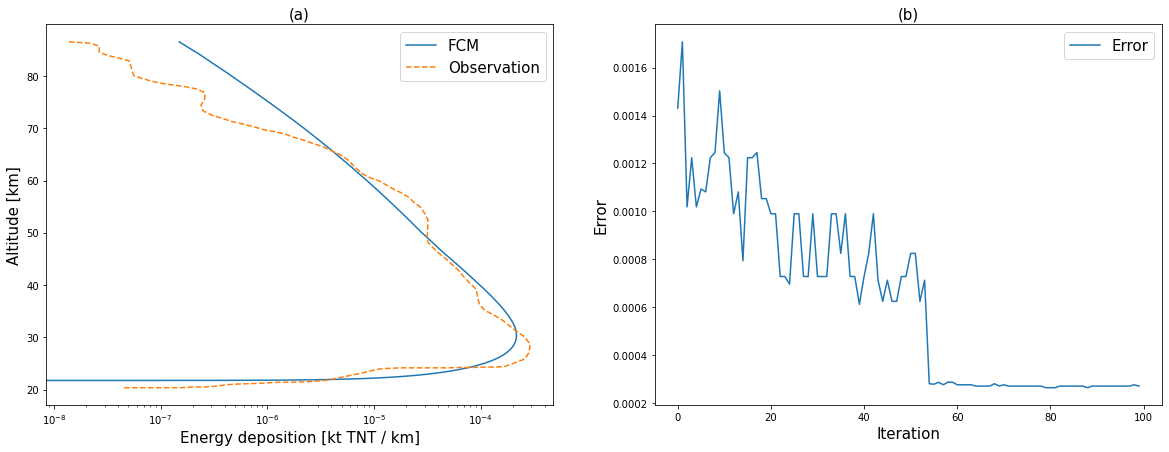

In [44]:
# t.plot_lost_city(simudata.energy_deposition, observation)

dEdz = simudata.energy_deposition
mask = np.logical_and(dEdz.index.to_numpy() >= observation.index.min(),
                      dEdz.index.to_numpy() <= observation.index.max())

fig, ax = plt.subplots(1, 2, figsize=(20,7))
# plot the energy deposition curve
ax[0].plot(dEdz.to_numpy()[mask], dEdz.index.to_numpy()[mask], label='FCM')
ax[0].plot(observation['dEdz [kt TNT / km]'].to_numpy(), observation.index.to_numpy(),
        "--", label='Observation')

ax[0].title.set_size(15)
ax[0].title.set_text("(a)")
ax[0].set_xlabel("Energy deposition [kt TNT / km]", fontsize=15)
ax[0].set_ylabel("Altitude [km]", fontsize=15)
ax[0].set_xscale('log')
ax[0].legend(loc='best', fontsize=15)

# plot the fitness
error = np.zeros(iteration)
error = [np.max(erro_list[i]) for i in range(iteration)]

print(fitness_list.min())
ax[1].plot(range(iteration), error, label='Error')
ax[1].title.set_size(15)
ax[1].title.set_text("(b)")
ax[1].set_xlabel("Iteration", fontsize=15)
ax[1].set_ylabel("Error", fontsize=15)
# ax[1].set_xscale('log')
ax[1].legend(loc='best', fontsize=15)

# plt.savefig("lost_city_image.png")

In [40]:
simudata.energy_deposition.to_csv("lost_city_data.csv")
np.savetxt("lost_city_one_structrue_group.csv", error)

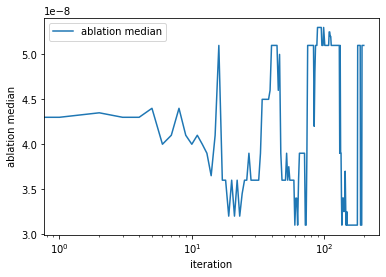

In [36]:
# plot the median of ablation trend
ablation_median = np.zeros(iteration)
ablation_median = [np.median(ablation[i]) for i in range(iteration)[:highest]]

plt.plot(range(iteration)[:highest], ablation_median[:highest], label='ablation median')
    
plt.xlabel("iteration")
plt.ylabel("ablation median")
plt.xscale('log')
plt.legend(loc='best')
plt.show()


[0.26, 0.26, 0.25, 0.25, 0.24, 0.24, 0.25, 0.25, 0.25, 0.25, 0.25, 0.24, 0.23, 0.23, 0.23, 0.23, 0.24, 0.23, 0.23, 0.24, 0.235, 0.24, 0.24, 0.24, 0.24, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.22, 0.22, 0.22, 0.22, 0.22, 0.215, 0.21, 0.21, 0.21, 0.21, 0.2, 0.2, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.22, 0.21, 0.22, 0.22, 0.22, 0.21, 0.22, 0.21, 0.21, 0.21, 0.21, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.21, 0.21, 0.2, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.23, 0.21, 0.21, 0.21, 0.22, 0.21, 0.23, 0.23, 0.23, 0.21, 0.21, 0.21, 0.22, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.23, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.21, 0.2, 0.2, 0.21, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,

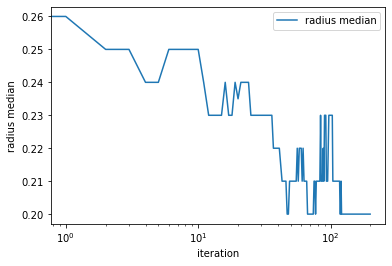

In [37]:
radius_median = np.zeros(iteration)
radius_median = [np.median(radius[i]) for i in range(iteration)]
print(radius_median)

plt.plot(range(iteration), radius_median, label='radius median')
    
plt.xlabel("iteration")
plt.ylabel("radius median")
plt.xscale('log')
plt.legend(loc='best')
plt.show()

7.823890426825358e-05


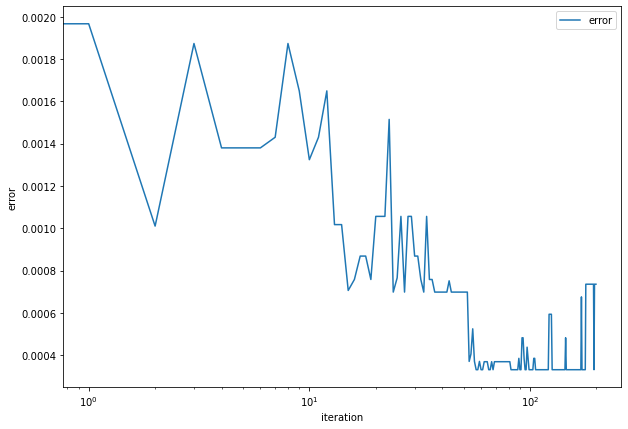

In [38]:
error = np.zeros(iteration)
error = [np.max(erro_list[i]) for i in range(iteration)]

np.savetxt("lost_city_one_structrue_group.csv", error)

print(erro_list.min())
fig, ax = plt.subplots(1, 1, figsize=(10, 7))
plt.plot(range(iteration), error, label='error')

    
plt.xlabel("iteration")
plt.ylabel("error")
plt.xscale('log')
plt.legend(loc='best')
plt.show()